## 1 Set Up
This code is for implementing the DAG on each value of theta and reporting results in graphs. Note that the initial values for f1 and f2 depend on theta. For reporting IRF of output gap, we also have to run the flexible prices equilibrium.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, create_model, solved

@simple 
def HH(N, C, gamma, varphi, chi, beta):
    WP = chi * (N ** varphi) / (C ** (-gamma))
    S = beta * (C(+1) ** (- gamma)) / (C ** (- gamma)) 
    EtRt1 = 1 / (beta * (C(+1) ** (-gamma)) / (C ** (-gamma)))
    return WP, S, EtRt1

def initial_f1_f2(theta):
    f1_init = 10 / (9 * (1 - 0.99 * theta))
    f2_init = 1 / (1 - 0.99 * theta)
    return f1_init, f2_init

def create_firms_block(theta):
    f1_init, f2_init = initial_f1_f2(theta)
    
    @solved(unknowns={'f1': f1_init, 'f2': f2_init}, targets=['f1eq', 'f2eq'], solver="broyden_custom")
    def firms(f1, f2, mu, N, WP, theta, pi, S, e, A):
        Y = A * N
        
        f1eq = ((1 + mu) *  N * WP ) + theta * (pi(+1) ** e)  * S * f1(+1) - f1
        f2eq =  A * N + theta * S * f2(+1) * (pi(+1) ** (e - 1)) - f2

        pstar = f1 / f2
        return Y, pstar, f1eq, f2eq
    
    return firms

@simple
def central_bank(pi, phi_pi, beta):
    Q = (pi ** (phi_pi)) / beta  # Taylor rule with phi_y=0
    return Q

@simple
def mkt_clearing(Y, Q, pi, C, EtRt1, pstar, theta, e):
    goods_mkt = Y - C
    inflation = 1 - theta * (pi ** (e - 1)) - (1 - theta) * (pstar ** (1-e))
    fisher = EtRt1 - Q / pi(+1)
    return goods_mkt, inflation, fisher




## 2 Flexible prices

In [15]:
theta = 0

firms = create_firms_block(theta)

nk = create_model([HH, firms, central_bank, mkt_clearing], name="NK")

# Parameters
gamma = 1.0
beta = 0.99
phi_pi = 1.5
e = 10.0 
mu = 1 / (e-1)
chi = 1.0
varphi = 1.0

# Calibration base
calibration_base = {'C': 1, 'WP': 1, 'Pi': 1, 'pstar': 1, 'S': 1, 'N': 1, 'Q': 1, 
                        'Y': 1, 'EtRt1': 1, 
                        'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'e': e, 
                        'mu': mu, 'varphi': varphi, 'chi': chi, 'A': 1, 'theta': theta}

unknowns_ss = {'pi': 1., 'N': 1., 'C': 1.}
targets_ss = {"goods_mkt": 0, "inflation": 0, "fisher": 0}

# Solve steady state with initial guesses for f1 and f2 and other unknowns
ss_flex = nk.solve_steady_state(calibration_base, unknowns_ss, targets_ss, solver="broyden_custom")
    

# Solve Jacobian
unknowns = ['pi', 'N', 'C']
targets = ['goods_mkt','inflation', 'fisher']
inputs = ['A']

G_flex = nk.solve_jacobian(ss_flex, unknowns, targets, inputs, T=300)

T, Tplot, impact, rho, news = 300, 20, 0.01, 0.8, 10
dA = np.empty((T, 1))
dA[:, 0] = impact * rho**np.arange(T)
dY_flex = 100 * G_flex['Y']['A'] @ dA / ss_flex['Y']




## 3 Loop on theta values

Produces the figures

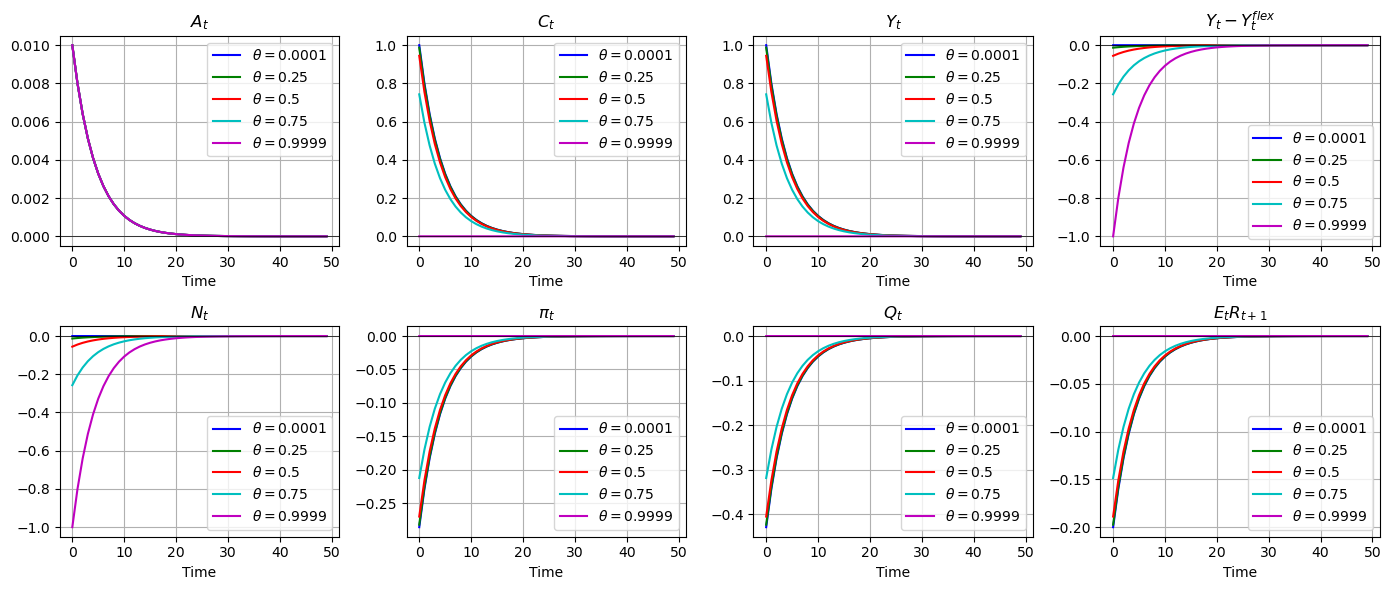

In [43]:
theta_values = [0.0001, 0.25, 0.5, 0.75, 0.9999]
results = {}

for theta in theta_values:
    firms = create_firms_block(theta)
    nk = create_model([HH, firms, central_bank, mkt_clearing], name="NK")

    # Parameters
    gamma = 1.0
    beta = 0.99
    phi_pi = 1.5
    e = 10.0 
    mu = 1 / (e-1)
    chi = 1.0
    varphi = 1.0

    # Calibration base
    calibration_base = {'C': 1, 'WP': 1, 'Pi': 1, 'pstar': 1, 'S': 1, 'N': 1, 'Q': 1, 
                        'Y': 1, 'EtRt1': 1, 
                        'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'e': e, 
                        'mu': mu, 'varphi': varphi, 'chi': chi, 'A': 1, 'theta': theta}

    unknowns_ss = {'pi': 1., 'N': 1., 'C': 1.}
    targets_ss = {"goods_mkt": 0, "inflation": 0, "fisher": 0}

    # Solve steady state with initial guesses for f1 and f2 and other unknowns
    ss = nk.solve_steady_state(calibration_base, unknowns_ss, targets_ss, solver="broyden_custom")
    
    # Solve Jacobian
    G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)
    
    # Store results
    results[theta] = {'ss': ss, 'G': G}

# Plotting IRFs for each theta
T, Tplot, impact, rho, news = 300, 20, 0.01, 0.8, 10
dA = np.empty((T, 1))
dA[:, 0] = impact * rho**np.arange(T)

fig, axs = plt.subplots(2, 4, figsize=(14, 6), facecolor='white')

colors = ['b', 'g', 'r', 'c', 'm']

for color, theta in zip(colors, theta_values):
    G = results[theta]['G']
    ss = results[theta]['ss']
    
    dC = 100 * G['C']['A'] @ dA / ss['C']
    dY = 100 * G['Y']['A'] @ dA / ss['Y']
    dG = dY - dY_flex 
    dN = 100 * G['N']['A'] @ dA / ss['N']
    dpi = 100 * G['pi']['A'] @ dA / ss['pi']
    dQ = 100 * G['Q']['A'] @ dA / ss['Q']
    dEtRt1 = 100 * G['EtRt1']['A'] @ dA / ss['EtRt1']

    axs[0,0].plot(dA[:50, 0], label=f'$\\theta={theta}$', color=color)
    axs[0,1].plot(dC[:50, 0], label=f'$\\theta={theta}$', color=color)
    axs[0,2].plot(dY[:50, 0], label=f'$\\theta={theta}$', color=color)
    axs[0,3].plot(dG[:50, 0], label=f'$\\theta={theta}$', color=color)
    axs[1,0].plot(dN[:50, 0], label=f'$\\theta={theta}$', color=color)
    axs[1,1].plot(dpi[:50, 0], label=f'$\\theta={theta}$', color=color)
    axs[1,2].plot(dQ[:50, 0], label=f'$\\theta={theta}$', color=color)
    axs[1,3].plot(dEtRt1[:50, 0], label=f'$\\theta={theta}$', color=color)


axs[0,0].axhline(0, color='black', linewidth=0.5)
axs[0,0].set_title('${A}_t$')
axs[0,0].set_xlabel('Time')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].axhline(0, color='black', linewidth=0.5)
axs[0,1].set_title('${C}_t$')
axs[0,1].set_xlabel('Time')
axs[0,1].grid(True)
axs[0,1].legend()

axs[0,2].axhline(0, color='black', linewidth=0.5)
axs[0,2].set_title('${Y}_t$')
axs[0,2].set_xlabel('Time')
axs[0,2].grid(True)
axs[0,2].legend()

axs[0,3].axhline(0, color='black', linewidth=0.5)
axs[0,3].set_title('${Y}_t-{Y}_t^{flex}$')
axs[0,3].set_xlabel('Time')
axs[0,3].grid(True)
axs[0,3].legend()

axs[1,0].axhline(0, color='black', linewidth=0.5)
axs[1,0].set_title('${N}_t$')
axs[1,0].set_xlabel('Time')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].axhline(0, color='black', linewidth=0.5)
axs[1,1].set_title('${\\pi}_t$')
axs[1,1].set_xlabel('Time')
axs[1,1].grid(True)
axs[1,1].legend()

axs[1,2].axhline(0, color='black', linewidth=0.5)
axs[1,2].set_title('${Q}_t$')
axs[1,2].set_xlabel('Time')
axs[1,2].grid(True)
axs[1,2].legend()

axs[1,3].axhline(0, color='black', linewidth=0.5)
axs[1,3].set_title('${E_{t}R_{t+1}}$')
axs[1,3].set_xlabel('Time')
axs[1,3].grid(True)
axs[1,3].legend()

plt.tight_layout()
plt.show()